In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
import healpy as hp

In [2]:
def get_alms(powers, label):
    # get the power spectrum
    aCls = powers[label]

    lmax = aCls.shape[0]-1
    aL = np.arange(lmax+1)

    aClTT = aCls[:,0]/aL/(aL+1)*2*np.pi
    aClTT[0]=0;aClTT[1]=0
    aClEE = aCls[:,1]/aL/(aL+1)*2*np.pi
    aClEE[0]=0;aClEE[1]=0
    aClBB = aCls[:,2]/aL/(aL+1)*2*np.pi
    aClBB[0]=0;aClBB[1]=0
    aClTE = aCls[:,3]/aL/(aL+1)*2*np.pi
    aClTE[0]=0;aClTE[1]=0

    alms_T, alms_E, alms_B = hp.synalm([aClTT,aClEE,aClBB,aClTE],lmax=2000,new=True,)
    
    return alms_T, alms_E, alms_B

def get_tqu_maps(alms_T, alms_E, alms_B):
    # generate the map
    TQU_maps = hp.alm2map([alms_T,alms_E,alms_B],lmax=2000,nside=512)
    # T,Q,U map
    T_map = TQU_maps[0]
    Q_map = TQU_maps[1]
    U_map = TQU_maps[2]
    
    return T_map, Q_map, U_map

def get_smoothed_maps(T_map, Q_map, U_map):
    tmap_smth = hp.smoothing(T_map, fwhm=0.5*np.pi/180)
    qmap_smth = hp.smoothing(Q_map, fwhm=0.5*np.pi/180)
    umap_smth = hp.smoothing(U_map, fwhm=0.5*np.pi/180)
    
    return tmap_smth, qmap_smth, umap_smth

def get_hot_coldspots(map, sort=True):
    spotmap, coldspots, hotspots = hp.hotspots(map)
    if sort:
        hsort = np.argsort(map[hotspots])[::-1]
        csort = np.argsort(map[coldspots])
        
        return coldspots[csort], hotspots[hsort]
    else:
        return coldspots, hotspots

In [3]:
# Use the provided planck2018 initial file
planck2018pars = camb.read_ini("planck_2018.ini")
planck2018 = camb.get_results(planck2018pars)
# get the power spectrum
powers = planck2018.get_cmb_power_spectra(planck2018pars,CMB_unit='muK')

tm1, qm1, um1 = get_tqu_maps(*get_alms(powers, 'unlensed_scalar'))

tsm1, qsm1, usm1 = get_smoothed_maps(tm1, qm1, um1)

c1, h1 = get_hot_coldspots(tsm1)


/tmp/ipykernel_644975/2851424362.py:8: RuntimeWarning: invalid value encountered in divide
  aClTT = aCls[:,0]/aL/(aL+1)*2*np.pi
/tmp/ipykernel_644975/2851424362.py:10: RuntimeWarning: invalid value encountered in divide
  aClEE = aCls[:,1]/aL/(aL+1)*2*np.pi
/tmp/ipykernel_644975/2851424362.py:12: RuntimeWarning: invalid value encountered in divide
  aClBB = aCls[:,2]/aL/(aL+1)*2*np.pi
/tmp/ipykernel_644975/2851424362.py:14: RuntimeWarning: invalid value encountered in divide
  aClTE = aCls[:,3]/aL/(aL+1)*2*np.pi


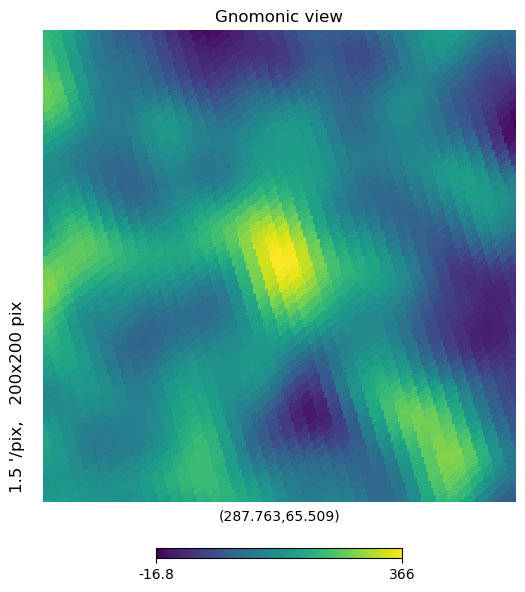

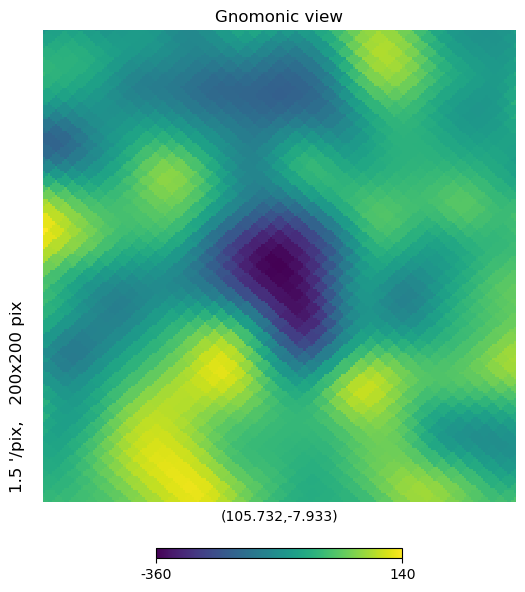

In [9]:
# from tqdm import trange
hlons1, hlats1 = hp.pix2ang(nside=512, ipix=h1, lonlat=True)
clons1, clats1 = hp.pix2ang(nside=512, ipix=c1, lonlat=True)

# hmaps = []
# cmaps = []
i=4
# for i in trange(500):
hmap = hp.visufunc.gnomview(tsm1, rot=(hlons1[i], hlats1[i], 0), xsize=200, return_projected_map=True, no_plot=False)
cmap = hp.visufunc.gnomview(tsm1, rot=(clons1[i], clats1[i], 0), xsize=200, return_projected_map=True, no_plot=False)
#     hmaps.append(hmap)
#     cmaps.append(cmap)



In [6]:
# hmap = np.sum(hmaps, axis=0)
# cmap = np.sum(cmaps, axis=0)

In [59]:
hmaps = np.load('hotmap.npy')
cmaps = np.load('coldmap.npy')
hmap = np.mean(hmaps, axis=0)
cmap = np.mean(cmaps, axis=0)

In [36]:
%config inlineBackend.figure_format = 'retina'

/tmp/ipykernel_2216511/1589786276.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_xticklabels([-100, -10, -1, 0, 1, 10, 100])


Text(0.5, 1.01, 'Coldspot Map')

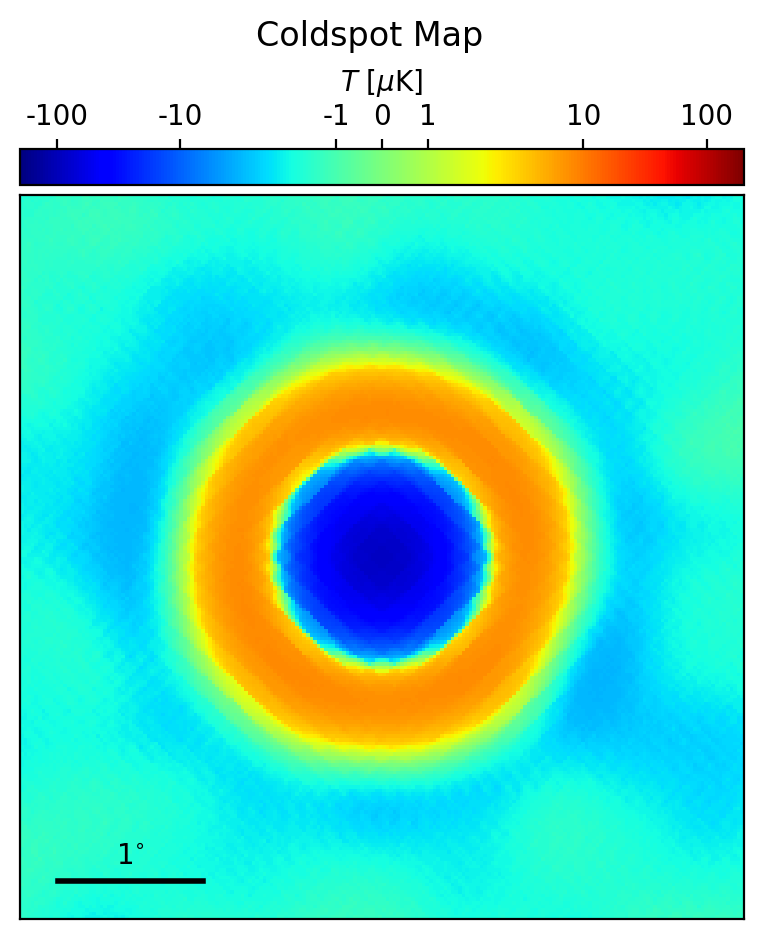

In [63]:
from matplotlib.colors import PowerNorm, LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
def draw_tmap(ax, tmap, caxloc='top'):
    im = ax.imshow(tmap, cmap='jet', norm=SymLogNorm(linthresh=3, linscale=1, vmax=200, vmin=-200), origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot([10, 50], [10, 10], 'k-', lw=2)
    ax.text(30, 15, r"$1^{\circ}$", ha='center', c='k')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(caxloc, size='5%', pad=0.05)
    plt.colorbar(im, cax=cax, orientation='horizontal')
    cax.set_xlabel('$T$ [$\mu$K]')
    cax.xaxis.set_ticks_position(caxloc)
    cax.xaxis.set_label_position(caxloc)
    cax.set_xticklabels([-100, -10, -1, 0, 1, 10, 100])
    
draw_tmap(ax, cmap)
fig.suptitle('Coldspot Map', position=(0.5, 1.01))

/tmp/ipykernel_2216511/518679421.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([100, 10, 1, 0, -1, -10, -100])


[Text(1, -100.0, '100'),
 Text(1, -10.0, '10'),
 Text(1, -1.0, '1'),
 Text(1, 0.0, '0'),
 Text(1, 1.0, '-1'),
 Text(1, 10.0, '-10'),
 Text(1, 100.0, '-100')]

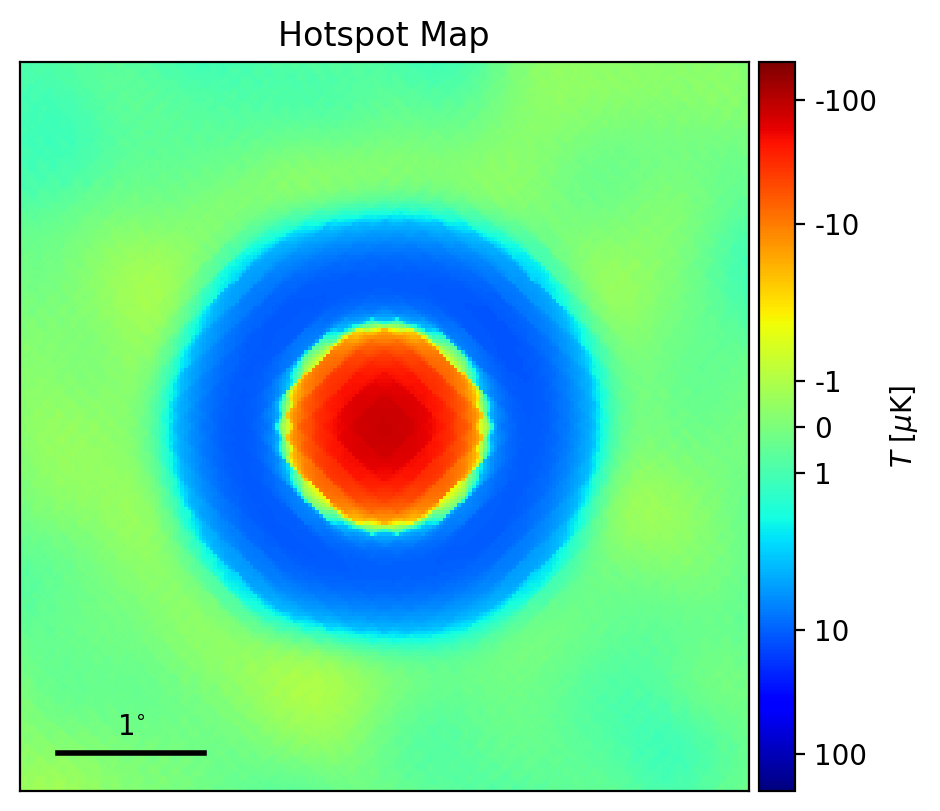

In [62]:
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
im = ax.imshow(hmap, cmap='jet', norm=SymLogNorm(linthresh=3, linscale=1, vmax=200, vmin=-200), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])
ax.plot([10, 50], [10, 10], 'k-', lw=2)
ax.text(30, 15, r"$1^{\circ}$", ha='center', c='k')
ax.set_title('Hotspot Map')
cax.set_ylabel('$T$ [$\mu$K]')
cax.set_yticklabels([100, 10, 1, 0, -1, -10, -100])

In [7]:
nside=512
qsm, usm = qsm1, usm1
xsize=200
i=0
ipix = np.arange(hp.nside2npix(nside))
hlons1, hlats1 = hp.pix2ang(nside=512, ipix=h1, lonlat=True)
clons1, clats1 = hp.pix2ang(nside=512, ipix=c1, lonlat=True)
lons, lats = hlons1, hlats1

from tqdm import trange
qrms, urms = [], []
for i in trange(100):
    local_qsm = hp.visufunc.gnomview(qsm, rot=(lons[i], lats[i], 0), xsize=xsize, return_projected_map=True, no_plot=True)
    local_usm = hp.visufunc.gnomview(usm, rot=(lons[i], lats[i], 0), xsize=xsize, return_projected_map=True, no_plot=True)
    local_imp = hp.visufunc.gnomview(ipix, rot=(lons[i], lats[i], 0), xsize=xsize, return_projected_map=True, no_plot=True)
    orig_tht, orig_phi = hp.pix2ang(nside, ipix=local_imp.data.astype(int).ravel())
    proj = hp.projector.GnomonicProj(xsize=xsize, rot=(lons[i], lats[i], 0))
    local_x, local_y = proj.ang2xy(orig_tht, orig_phi)
    local_phi = np.arctan2(local_y, local_x[::-1]).reshape(xsize, xsize)
    local_qrm = - local_qsm*np.cos(2*local_phi) - local_usm*np.sin(2*local_phi)
    local_urm = local_qsm*np.sin(2*local_phi) - local_usm*np.cos(2*local_phi)
    qrms.append(local_qrm)
    urms.append(local_urm)
    
qrm = np.sum(qrms, axis=0)
urm = np.sum(urms, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


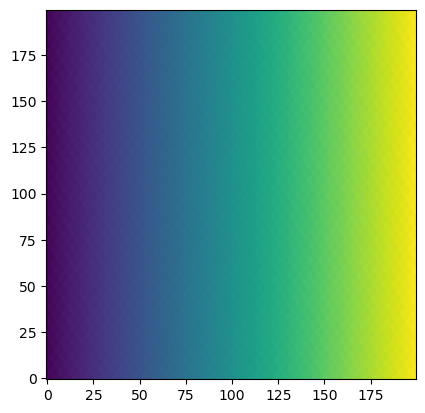

In [8]:
plt.imshow(local_x.reshape(xsize, xsize), origin='lower')

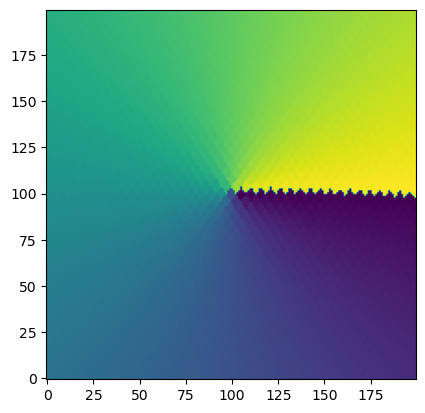

In [9]:
plt.imshow(local_phi.reshape(xsize, xsize), origin='lower')

In [34]:
hqrm = np.mean(np.load('hqmaps.npy'), axis=0)
cqrm = np.mean(np.load('cqmaps.npy'), axis=0)
hurm = np.mean(np.load('humaps.npy'), axis=0)
curm = np.mean(np.load('cumaps.npy'), axis=0)
hqsm = -np.mean(np.load('hqmaps_bkp.npy'), axis=0)
cqsm = -np.mean(np.load('cqmaps_bkp.npy'), axis=0)
husm = -np.mean(np.load('humaps_bkp.npy'), axis=0)
cusm = -np.mean(np.load('cumaps_bkp.npy'), axis=0)

[Text(1, -1.0, '-1'),
 Text(1, -0.1, '-0.1'),
 Text(1, 0.0, '0'),
 Text(1, 0.1, '0.1'),
 Text(1, 1.0, '1')]

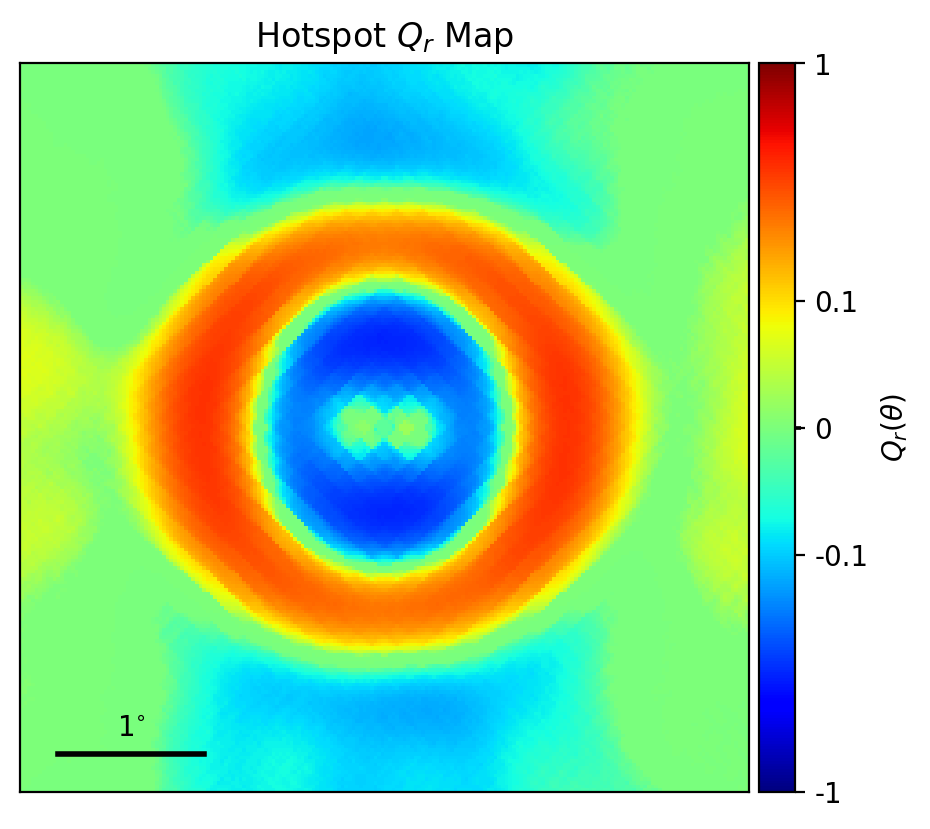

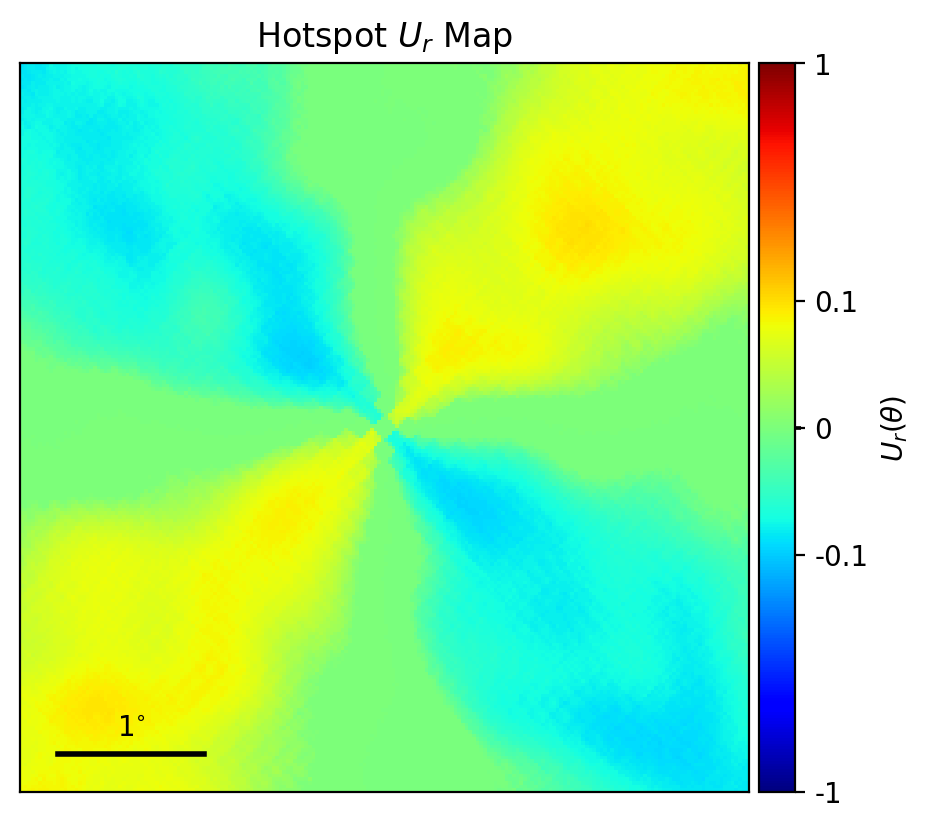

In [5]:
from matplotlib.colors import PowerNorm, LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
im = ax.imshow(hqrm, cmap='jet', norm=SymLogNorm(linthresh=0.03, linscale=0.01, vmax=1, vmin=-1), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])
ax.plot([10, 50], [10, 10], 'k-', lw=2)
ax.text(30, 15, r"$1^{\circ}$", ha='center', c='k')
ax.set_title('Hotspot $Q_r$ Map')
cax.set_ylabel(r'$Q_r(\theta)$')
cax.set_yticks([-1, -0.1, 0, 0.1, 1])
cax.set_yticklabels([-1, -0.1, 0, 0.1, 1])


fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
im = ax.imshow(hurm, cmap='jet', norm=SymLogNorm(linthresh=0.03, linscale=0.01, vmax=1, vmin=-1), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])
ax.plot([10, 50], [10, 10], 'k-', lw=2)
ax.text(30, 15, r"$1^{\circ}$", ha='center', c='k')
ax.set_title('Hotspot $U_r$ Map')
cax.set_ylabel(r'$U_r(\theta)$')
cax.set_yticks([-1, -0.1, 0, 0.1, 1])
cax.set_yticklabels([-1, -0.1, 0, 0.1, 1])


In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

class Rods():
    def __init__(self, x, y, l, w=1, angle=0, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.color = kwargs.pop("color", "lightblue")
        self.lw = 1
        self.ax.figure.canvas.draw()
        self.ppd = 72. / self.ax.figure.dpi
        self.trans = self.ax.transData.transform
        self.lines = []
        self.set_data(x, y, l, w, angle)

        self.cid = self.ax.figure.canvas.mpl_connect('resize_event', self._resize)
        self.cid1 = self.ax.figure.canvas.mpl_connect("motion_notify_event", self._resize)
        self.cid2 = self.ax.figure.canvas.mpl_connect('button_release_event', self._resize)

    def set_data(self, x, y, l, w=1, angle=0, color=None):
        if color:
            self.color = color
        self.lw_data = w

        # Ensure angle is an array for broadcasting
        if not isinstance(angle, np.ndarray):
            angle = np.full(len(x), angle, dtype=float)

        # Compute transformation for each angle
        x_points = np.zeros((len(x), 2, 2))  # Array to store line endpoints (x1, x2)
        y_points = np.zeros((len(x), 2, 2))  # Array to store line endpoints (y1, y2)

        # Loop over each rod
        for i in range(len(x)):
            m = np.array([
                [np.cos(angle[i]), -np.sin(angle[i])],
                [np.sin(angle[i]), np.cos(angle[i])]
            ])
            xy1 = np.dot(m, np.array([0, -l[i] / 2]))
            xy2 = np.dot(m, np.array([0, l[i] / 2]))

            x_points[i] = [xy1[0] + x[i], xy2[0] + x[i]]
            y_points[i] = [xy1[1] + y[i], xy2[1] + y[i]]

        if self.lines:
            for line in self.lines:
                line.remove()
            self.lines = []

        # Create a line for each rod
        for i in range(len(x)):
            line = Line2D(x_points[i], y_points[i], solid_capstyle="round", color=self.color)
            self.lines.append(line)
            self.ax.add_artist(line)

        self._resize()

    def _resize(self, event=None):
        if self.lines:
            lw = ((self.trans((1, self.lw_data)) - self.trans((0, 0))) * self.ppd)[1]
            if lw != self.lw:
                for line in self.lines:
                    line.set_linewidth(lw)
                self.ax.figure.canvas.draw_idle()
                self.lw = lw

Text(0.5, 1.01, 'Hotspot $Q_r$ Map')

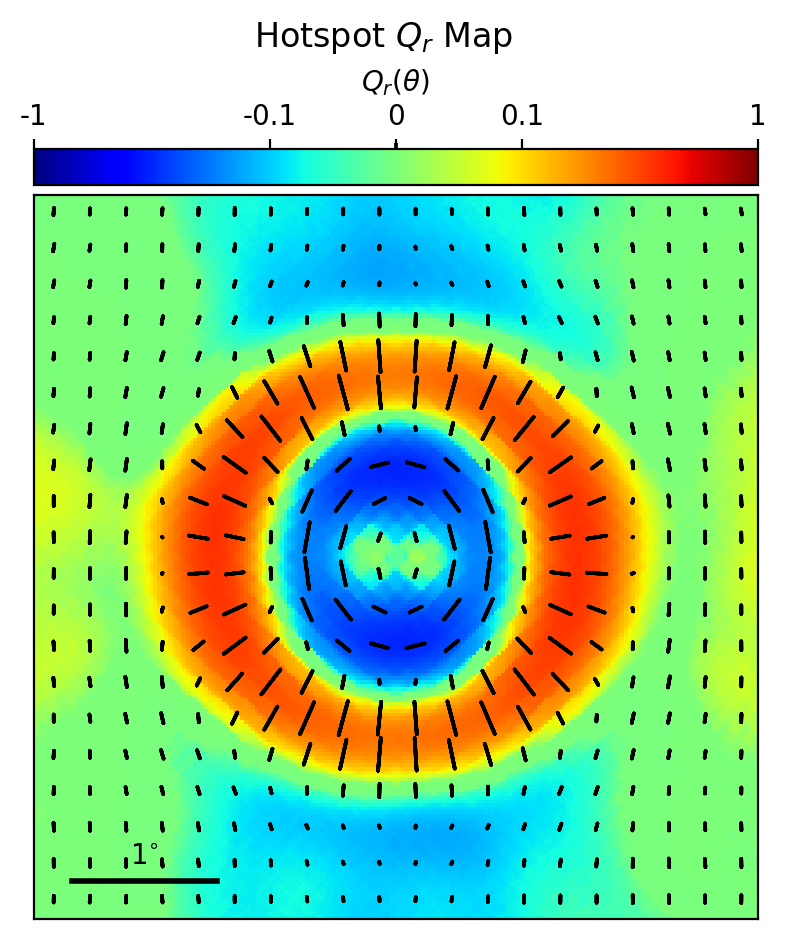

In [67]:
fig = plt.figure(figsize=(5, 5), dpi=200)
ax = fig.add_subplot(111)
def draw_qu(ax, qrm, qsm, usm, caxloc="top", cax_label="", draw_pol=True):
    im = ax.imshow(qrm, cmap='jet', norm=SymLogNorm(linthresh=0.03, linscale=0.01, vmax=1, vmin=-1), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(caxloc, size='5%', pad=0.05)
    plt.colorbar(im, cax=cax, orientation='horizontal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot([10, 50], [10, 10], 'k-', lw=2)
    ax.text(30, 15, r"$1^{\circ}$", ha='center', c='k')
    cax.set_xlabel(cax_label)
    cax.set_xticks([-1, -0.1, 0, 0.1, 1])
    cax.set_xticklabels([-1, -0.1, 0, 0.1, 1])
    cax.xaxis.set_ticks_position(caxloc)
    cax.xaxis.set_label_position(caxloc)

    if draw_pol:
        from skimage.measure import block_reduce
        qsm_ds = block_reduce(qsm, (10, 10), np.mean)
        usm_ds = block_reduce(usm, (10, 10), np.mean)

        chi = (np.arctan2(usm_ds[::-1], qsm_ds)/2).flatten()
        pp = np.sqrt(qsm_ds**2 + usm_ds**2).flatten()

        X, Y = np.meshgrid(np.arange(20), np.arange(20))
        x = X.flatten()*10+5
        y = Y.flatten()*10+5
        l = pp*30
        r = Rods(x,y,l,w=1, angle=chi, color="k", ax=ax)
    
draw_qu(ax, hqrm, hqsm, husm, cax_label=r'$Q_r(\theta)$')
fig.suptitle('Hotspot $Q_r$ Map', position=(0.5, 1.01))

/tmp/ipykernel_2216511/1589786276.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_xticklabels([-100, -10, -1, 0, 1, 10, 100])


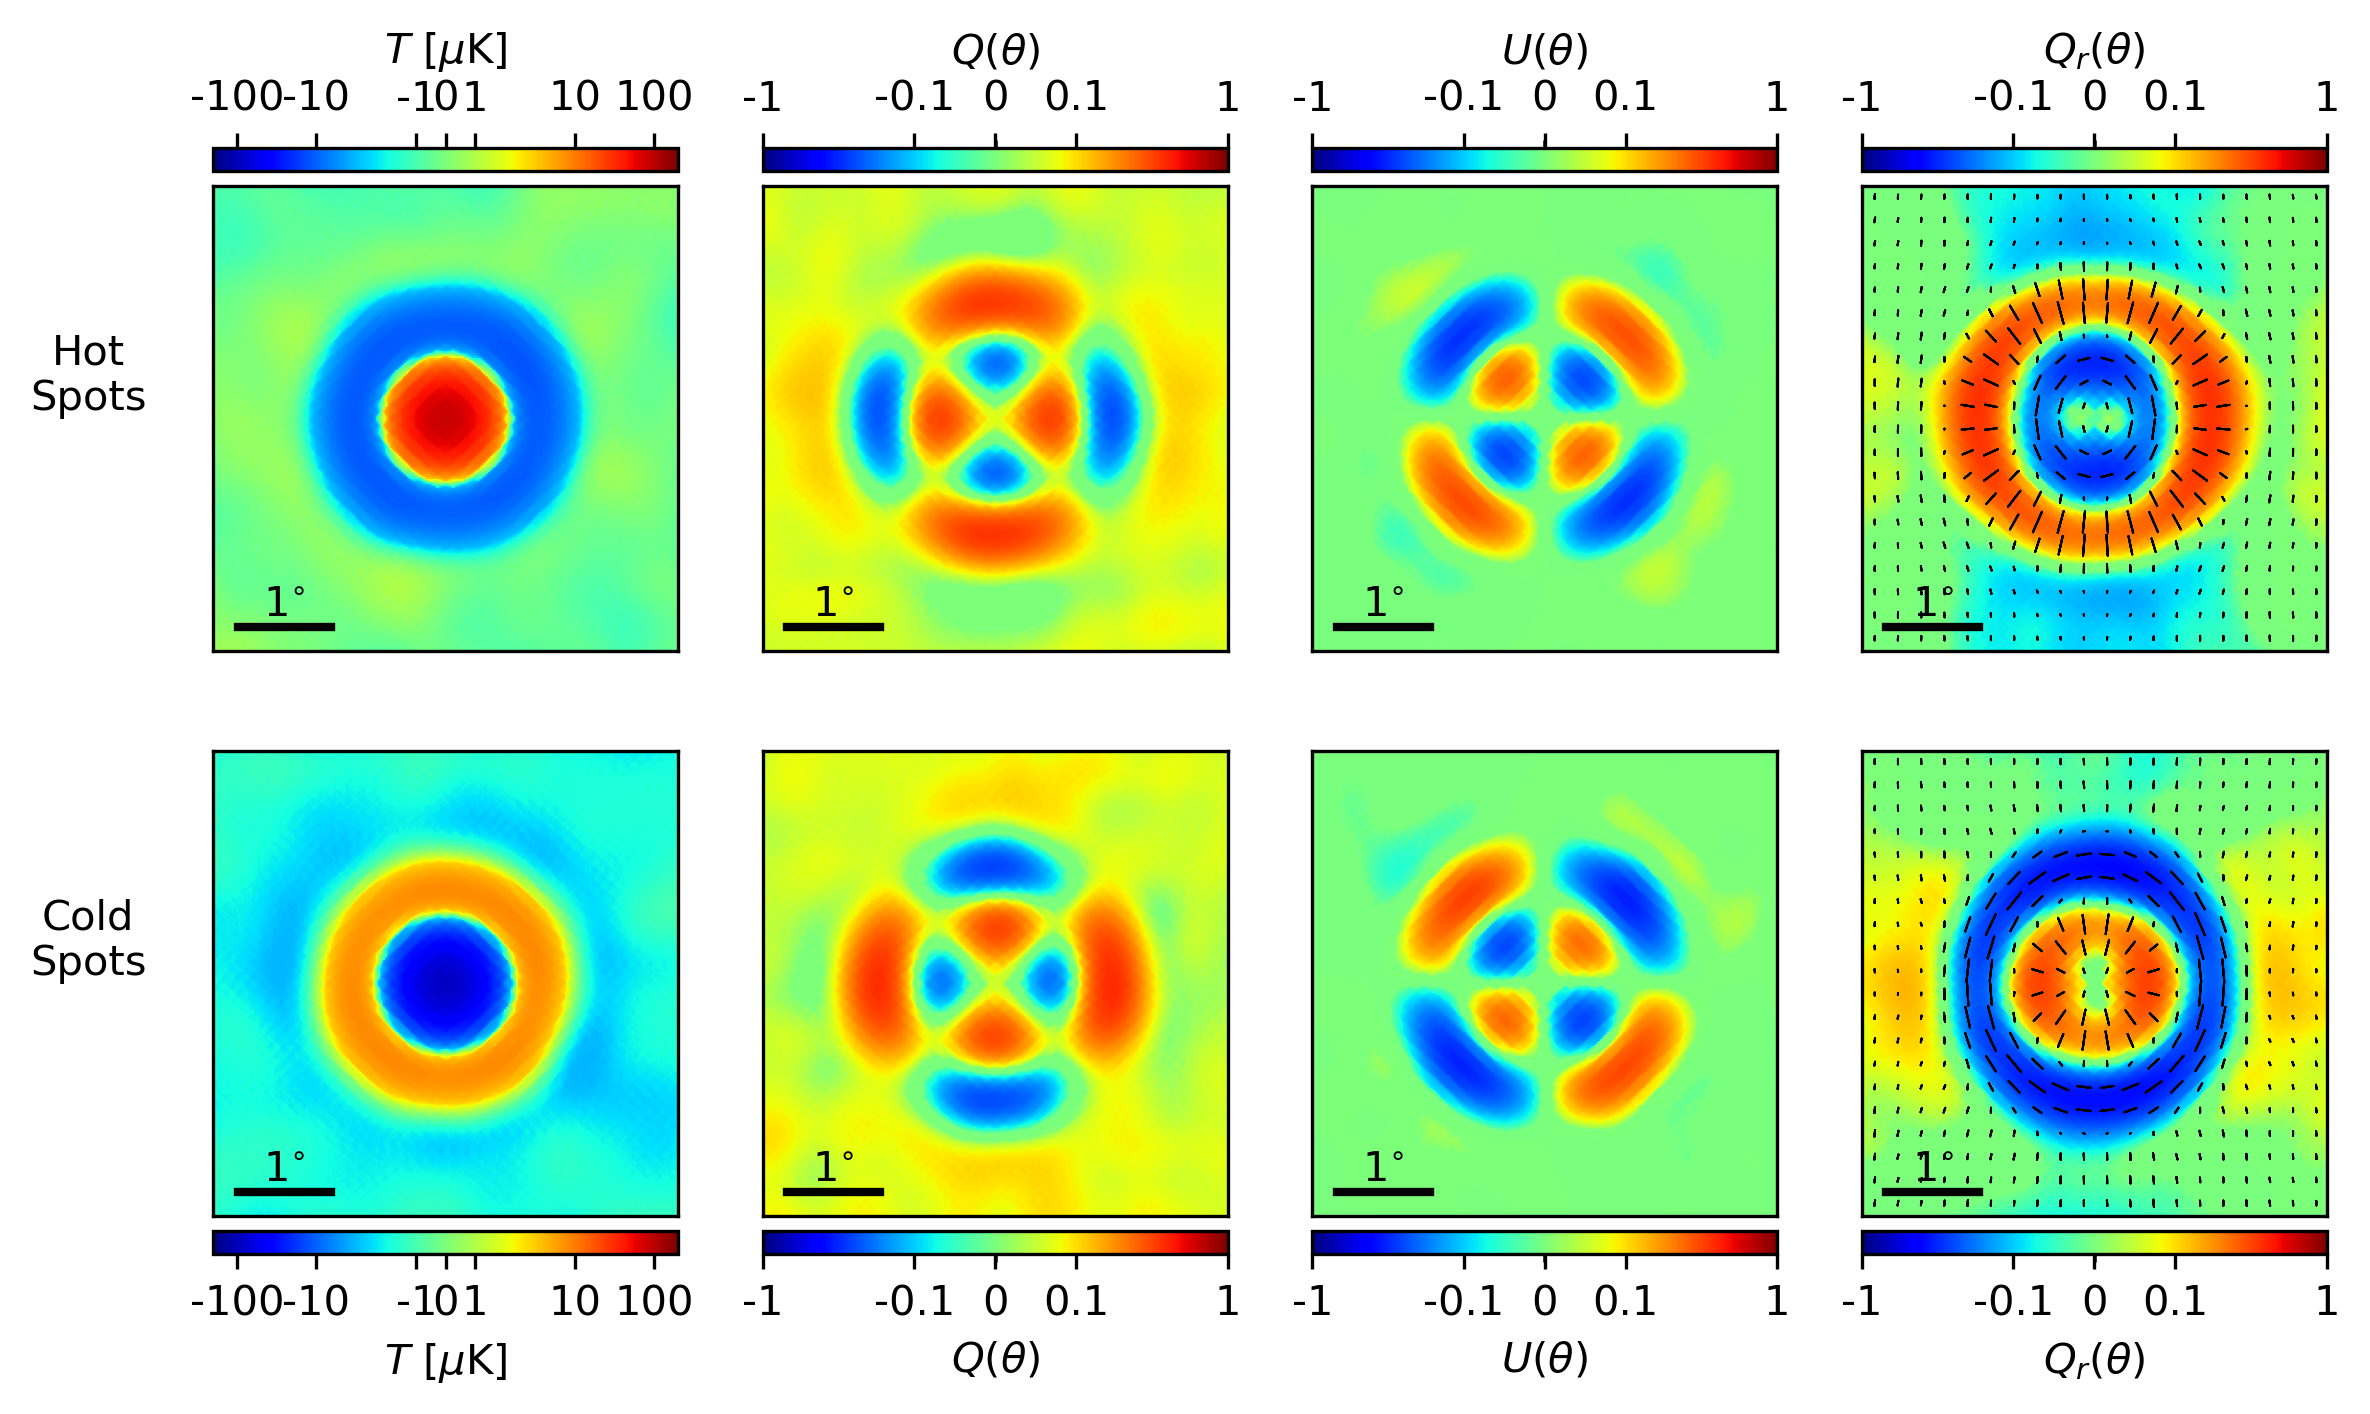

In [84]:
fig, axes = plt.subplots(2, 4, figsize=(8, 5), dpi=300)
draw_tmap(axes[0, 0], hmap, caxloc='top')
draw_qu(axes[0, 1], hqsm, hqsm, husm, draw_pol=False, caxloc='top', cax_label=r'$Q(\theta)$')
draw_qu(axes[0, 2], husm, hqsm, husm, draw_pol=False, caxloc='top', cax_label=r'$U(\theta)$')
draw_qu(axes[0, 3], hqrm, hqsm, husm, caxloc='top', cax_label=r'$Q_r(\theta)$')
draw_tmap(axes[1, 0], cmap, caxloc='bottom')
draw_qu(axes[1, 1], cqsm, cqsm, cusm, draw_pol=False, caxloc='bottom', cax_label=r'$Q(\theta)$')
draw_qu(axes[1, 2], cusm, cqsm, cusm, draw_pol=False, caxloc='bottom', cax_label=r'$U(\theta)$')
draw_qu(axes[1, 3], cqrm, cqsm, cusm, caxloc='bottom', cax_label=r'$Q_r(\theta)$')
axes[0, 0].set_ylabel('Hot\nSpots', rotation=0, labelpad=30)
axes[1, 0].set_ylabel('Cold\nSpots', rotation=0, labelpad=30)
fig.tight_layout()
fig.savefig('hot_cold_maps.png', dpi=300, bbox_inches='tight')